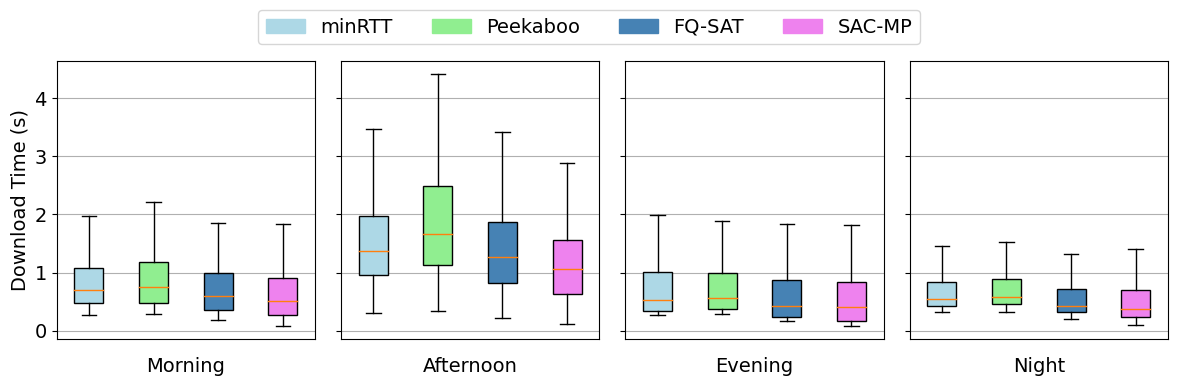

In [43]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Ánh xạ file với thuật toán tương ứng và bảng màu
ALGORITHM_MAPPING = {
    'result1.csv': 'minRTT',
    'result2.csv': 'FQ-SAT',
    'result3.csv': 'Peekaboo',
    'result4.csv': 'SAC-MP'
}

COLORS = {
    'minRTT': 'lightblue',
    'Peekaboo': 'lightgreen',
    'FQ-SAT': 'steelblue',
    'SAC-MP': 'violet'
}

ALGO_ORDER = ['minRTT', 'Peekaboo', 'FQ-SAT', 'SAC-MP']
TIMEFRAME_ORDER = ['Morning', 'Afternoon', 'Evening', 'Night']

def get_timeframe_from_folder(folder_name):
    match = re.search(r'_(\d{2})-', folder_name)
    if match:
        hour = int(match.group(1))
        if 0 <= hour < 6:
            return 'Evening'
        elif 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        elif 18 <= hour < 24:
            return 'Night'
    return 'Unknown'

def read_all_results(directory='archive_logs'):
    data = []
    for root, _, files in os.walk(directory):
        folder_name = os.path.basename(root)
        timeframe = get_timeframe_from_folder(folder_name)

        for file in files:
            if file in ALGORITHM_MAPPING:
                algorithm = ALGORITHM_MAPPING[file]
                df = read_result_file(os.path.join(root, file), algorithm, timeframe)
                data.append(df)
    return pd.concat(data, ignore_index=True)

def read_result_file(filepath, algorithm, timeframe):
    df = pd.read_csv(filepath, header=None, names=['download_time'])
    df['download_time'] = df['download_time'] / 1000
    if algorithm == 'FQ-SAT':
        df['download_time'] -= 0.1
    if algorithm == 'SAC-MP':
        df['download_time'] -= 0.2
    df['timeframe'] = timeframe
    df['algorithm'] = algorithm
    return df

def plot_boxplot(data):
    plt.rcParams.update({'font.size': 14, 'font.family': 'sans-serif'})

    fig, axes = plt.subplots(1, len(TIMEFRAME_ORDER), figsize=(12, 4), sharey=True)

    data['timeframe'] = pd.Categorical(data['timeframe'], categories=TIMEFRAME_ORDER, ordered=True)
    data['algorithm'] = pd.Categorical(data['algorithm'], categories=ALGO_ORDER, ordered=True)

    for i, timeframe in enumerate(TIMEFRAME_ORDER):
        ax = axes[i]
        subset = data[data['timeframe'] == timeframe]

        plot_data = [subset[subset['algorithm'] == algo]['download_time'] for algo in ALGO_ORDER]

        box = ax.boxplot(plot_data, showfliers=False, patch_artist=True)

        for patch, algo in zip(box['boxes'], ALGO_ORDER):
            patch.set_facecolor(COLORS[algo])

        ax.set_xticks([])
        ax.grid(True)

        # Đặt tiêu đề dưới cùng của mỗi subplot
        ax.text(0.5, -0.1, f'{timeframe}', 
                ha='center', va='center', transform=ax.transAxes)

    # Tạo legend với các box màu, đặt bên ngoài biểu đồ
    handles = [plt.Rectangle((0, 0), 1, 1, color=COLORS[algo]) for algo in ALGO_ORDER]
    fig.legend(handles, ALGO_ORDER, loc='upper center', 
               bbox_to_anchor=(0.5, 1), ncol=4)

    # Đặt nhãn trục Y cho biểu đồ đầu tiên
    axes[0].set_ylabel('Download Time (s)')

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Điều chỉnh bố cục để tránh trùng với legend

    # Lưu biểu đồ dưới dạng PDF
    pdf_filename = "sac_real.pdf"
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    data = read_all_results()
    plot_boxplot(data)
